In [236]:
%matplotlib inline
import pandas as pd
import numpy as np
import os, sys
from  sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as train_test_split
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,cross_val_score
from IPython.display import HTML, display
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer

import xgboost as xgb  #GBM algorithm
from xgboost import XGBRegressor
from sklearn import metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV 

In [3]:
try:
    os.path.exists("irs_public_data.csv")
except FileNotFoundError:
    print(' IRS File does not exist')

try:
    os.path.exists("acs_population_demographics.csv")
except FileNotFoundError:
    print(' ACS File does not exist')

    

    

# Overview
There are 166740 total instances in the irs_public_data file, and 13 attributes, of which "STATE" is the only categorical data, and 12 continuous data. By checking the missing values we found no missing values in this file. But we notice many 0s in the data file, like the zipcode,num_returns,amount_agi,which should not be 0 for an area, this should be regarded as missing values. Especially we want to calculate the relationship between the ratio of paid_preparer_returns(num_paid_preparer_returns/num_returns) with other attributes, so we also define the instances of num_returns == 0 as the missing values, this amounts to about 10% of all the data.
The first 10 rows give us a first glance of the data in irs_public_data file.

There are 33120 total instances in the acs_population_demographics file, and 65 attributes, the zipcode is encoded in the by the ZCTA(int values). And the missing values are mostly range from 200 to 400, account for 0.6%-1.2%.

In [4]:
IRS_df = pd.read_csv("irs_public_data.csv")
IRS_df.head(10)
print(len(IRS_df['STATE'].unique().tolist()))
print(IRS_df.isnull().values.any())
#gather some information about different column in IRS dataframe. 
print(IRS_df.info())

51
False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166740 entries, 0 to 166739
Data columns (total 13 columns):
STATE                            166740 non-null object
zipcode                          166740 non-null int64
agi_stub                         166740 non-null int64
num_returns                      166740 non-null int64
num_single_returns               166740 non-null int64
num_joint_returns                166740 non-null int64
num_head_of_household_returns    166740 non-null int64
num_paid_preparer_returns        166740 non-null int64
num_exemptions                   166740 non-null int64
num_dependents                   166740 non-null int64
amount_agi                       166740 non-null int64
num_returns_with_refunds         166740 non-null int64
amount_refunds                   166740 non-null int64
dtypes: int64(12), object(1)
memory usage: 16.5+ MB
None


In [5]:
missing_irs = IRS_df[IRS_df['num_returns']==0]
missing_irs = missing_irs['num_returns']
print("The number of instances with num of returns of 0 is: {:d}".format(missing_irs.count()))


The number of instances with num of returns of 0 is: 16973


## Missing values
I download from 'https://www.udsmapper.org/zcta-crosswalk.cfm'  of ZCTA data set. 
There is no zipcode corresponding to 0, so I delete the 5 rows with 0 zipcode. For further analysis, I also drop the missing values rows where the num_returns==0.
 


In [6]:
#df.drop(df[df.score < 50].index, inplace=True)
IRS_df = IRS_df.drop(IRS_df[IRS_df['zipcode'] == 0].index)
IRS_df = IRS_df.drop(IRS_df[IRS_df['num_returns'] == 0].index)


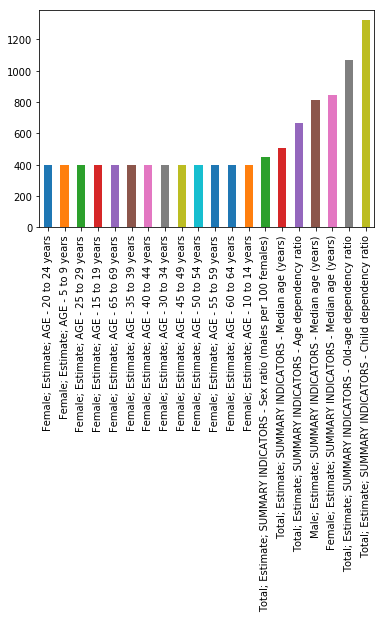

In [7]:
ACS_df = pd.read_csv("acs_population_demographics.csv")
ACS_df.head(5)
#print(len(ACS_df['ZIP'].unique().tolist()))
ACS_df.isnull().values.any()
missing_acs = ACS_df.isnull().sum()
missing_acs = missing_acs[missing_acs>0]
missing_acs.sort_values(inplace=True)
missing_acs.tail(20).plot.bar()
#null_data = ACS_df[ACS_df.isnull().any(axis=1)]



# Correlations between y and attributes
I used the heatmap to get a glance of the correalations, as from the covariates description, we found the covariates should have some correlations. Both cases some significant  correlation  between these variables. Actually, this correlation is so strong that it can indicate a situation of multicollinearity. 


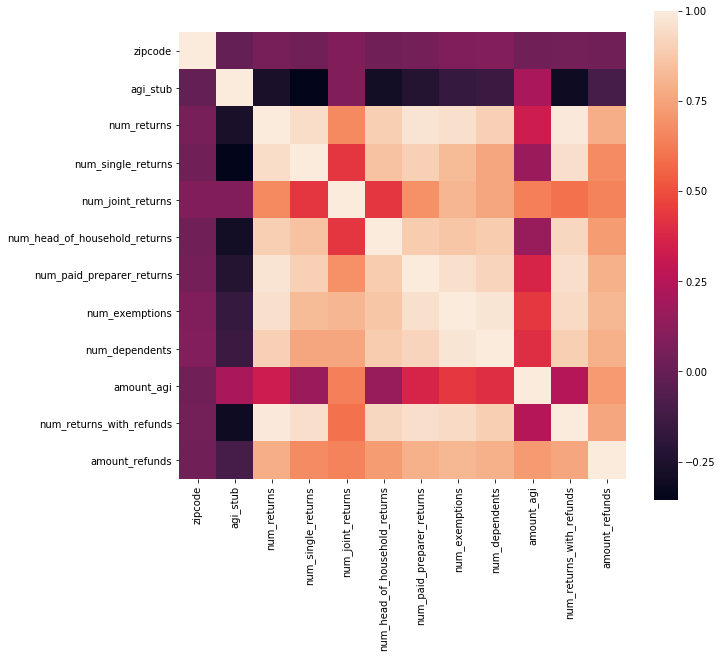

In [8]:
#correlation matrix
corrmat = IRS_df.corr()
f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(corrmat, vmax=1, square=True);

/Users/MingyangLiu/.local/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


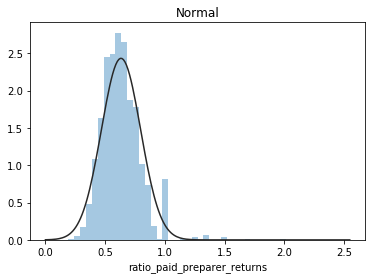

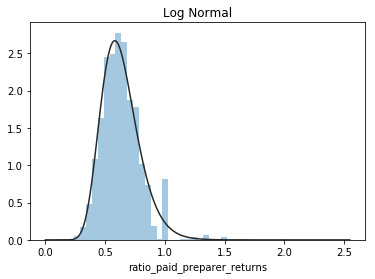

In [9]:
import scipy.stats as st

IRS_df['ratio_paid_preparer_returns']=IRS_df['num_paid_preparer_returns']/IRS_df['num_returns']
y = IRS_df[IRS_df['ratio_paid_preparer_returns']>0]['ratio_paid_preparer_returns']

#IRS_df['ratio_paid_preparer_returns'].isnull().values.any()
plt.figure(1); plt.title('Normal')
sns.distplot(y, kde=False,fit=st.norm)
plt.figure(2); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

The plot of ratio of paid preparer returns show a trend in log normal distribution, so it suggests a log norm transformation if performing linear regression methods.

# Feature Preprocessing
In order to compare across different states, I calculate the ratios of num_paid_preparer_returns in total number of returns (num_returns) as the metric, defined as 'ratio_paid_preparer_returns'.

As the only categorical variable in IRS data file, I first check the relationship between num_paid__preparer_returns and zipcode, if there is a strong relationship, then it should be necessary to join the two tables on zipcode. As the zipcode should be nominal categorical data, so I plot the relationship. And from the boxplot we may think the zipcode is a necessary variable to predict the ratio_paid__preparer_returns and we should join the two tables. 

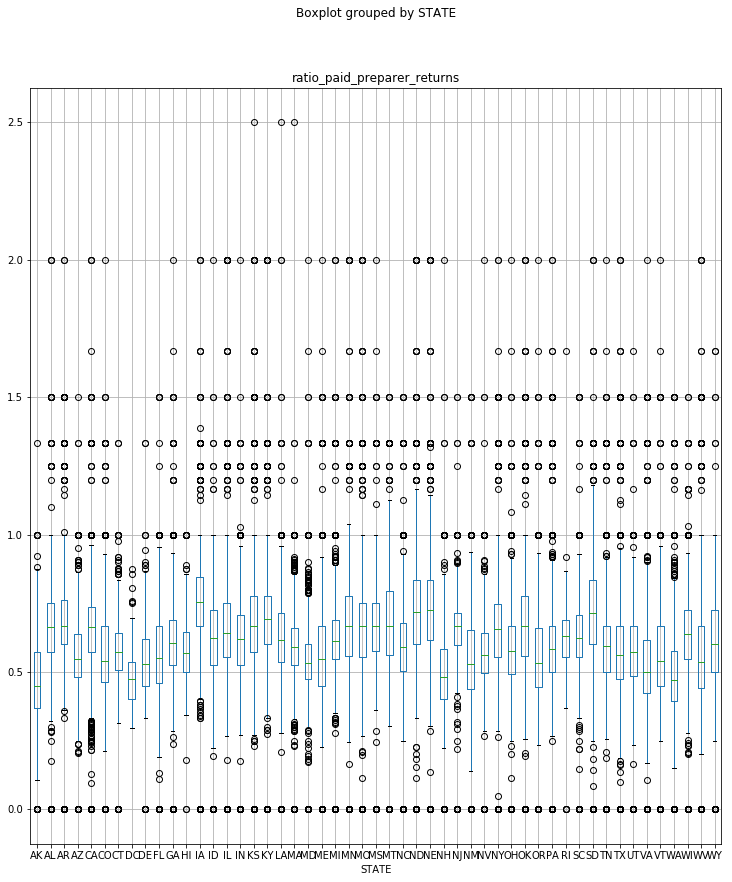

In [10]:

IRS_df['zipcode'].corr(IRS_df['num_paid_preparer_returns'])
IRS_df.boxplot('ratio_paid_preparer_returns','STATE',figsize=(12,14))

In [11]:
#df.drop(df[df.score < 50].index, inplace=True)
IRS_df = IRS_df.drop(IRS_df[IRS_df['zipcode'] == 0].index)
IRS_df = IRS_df.drop(IRS_df[IRS_df['num_returns'] == 0].index)



In [12]:

zcta_df = pd.read_excel('zip_to_zcta_2018.xlsx', sheet_name='ziptozcta2017')

zcta_df = zcta_df.rename(index=str, columns={"ZIP_CODE": "zipcode", "ZCTA": "ZIP"})
#zcta_df=zcta_df[zcta_df['zip_join_type']=='Zip Matches ZCTA']
zcta_df.head()

,zipcode,PO_NAME,STATE,ZIP_TYPE,ZIP,zip_join_type
0,501,Holtsville,NY,Post Office or large volume customer,11742,Spatial join to ZCTA
1,544,Holtsville,NY,Post Office or large volume customer,11742,Spatial join to ZCTA
2,601,Adjuntas,PR,ZIP Code Area,601,Zip Matches ZCTA
3,602,Aguada,PR,ZIP Code Area,602,Zip Matches ZCTA
4,603,Aguadilla,PR,ZIP Code Area,603,Zip Matches ZCTA


In [13]:

ACS_df=ACS_df.rename(index=str, columns={"ZIP": "zipcode"})
IRS_ACS=pd.merge(left=IRS_df,right=ACS_df,how='left',on='zipcode',left_index=True)



From the summary of acs_population_demographics we can find the zipcode is 33120 while in irs the zipcode is only 166740, so I used left join to combine the two tables together.

Next, I want to explore the relationship between income and the ratio_paid_preparer_returns, the following plot is  ratio_paid_preparer_returns  grouped  by Income levels for 10 states(due to the limitation of figure size, I only plot 10 states ). And from this plot we found the ratio_paid_preparer_returns is correlated with the income, in a trend that in the same state, the higher the income,  the more people are likely to pay for tax preparer. 

Text(0,0.5,'ratio_paid_preparer_returns')

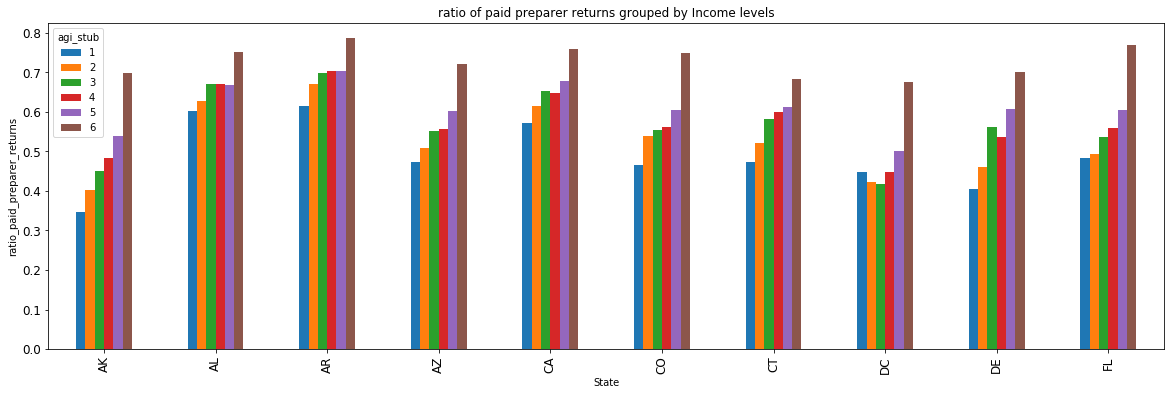

In [14]:

state_income_ratio = IRS_ACS.pivot_table(index=['STATE'], 
                                    columns=['agi_stub'], 
                                    values='ratio_paid_preparer_returns'
                                    ).head(10)

StateRatio_plot= state_income_ratio.plot(kind="bar",figsize=(20,6),fontsize=12,title = 'ratio of paid preparer returns grouped by Income levels')
StateRatio_plot.set_xlabel("State")
StateRatio_plot.set_ylabel("ratio_paid_preparer_returns")

So, currently, we found the ratio of paid preparer returns are corellated with state , zipcode  and gross income, both should be categorical data ,especially the zipcode has many levels while agi_stub only have 6 levels. So we need to change the zicode and agi_stub into categorical data and then encoding them.

In [91]:
IRS_ACS = IRS_ACS.rename(index=str,
                         columns={
                          "Total; Estimate; Total population": "total",
                          "Male; Estimate; Total population": "male",
                          "Female; Estimate; Total population": "female"})
IRS_ACS['male_ratio'] = IRS_ACS['male'] / IRS_ACS['total']
IRS_ACS['female_ratio'] = IRS_ACS['female'] / IRS_ACS['total']

IRS_ACS.shape


(149461, 81)

### Data Preprocessing:
- Conduct lognorm transformaltion on the ratio of paid_preparer_returns
- Create Dummy variables for the categorical features
- Normalize numerical variables
- Replace the numeric missing values (NaN's) with the mean of their respective columns


In [190]:
IRS_ACS['STATE'] = IRS_ACS['STATE'].astype('category')
IRS_ACS['zipcode'] = IRS_ACS['zipcode'].astype('int64')
IRS_ACS['agi_stub'] = IRS_ACS['agi_stub'].astype('category')



In [195]:
# select the useful columns
IRS_data=IRS_ACS.loc[:,['STATE','zipcode','agi_stub','num_single_returns','num_joint_returns','num_head_of_household_returns',
         'num_paid_preparer_returns','num_exemptions','num_dependents','amount_agi','num_returns_with_refunds','amount_refunds',
         'ratio_paid_preparer_returns','male_ratio','female_ratio']]
#IRS_data.info()

In [206]:
# Create Dummy variables for the categorical features
obj_columns = IRS_data.select_dtypes(include=['category']).columns.values
obj_values = pd.get_dummies(IRS_data.loc[:,('STATE','agi_stub')])
obj_values.head()

data = pd.get_dummies(IRS_data)
data['log_ratio_paid_preparer_returns'] = np.log1p(data['ratio_paid_preparer_returns']+1e-6)
data.head()
# cor_pd = pd.get_dummies(IRS_data2.loc[:,('STATE','agi_stub')])
# cor_pd.head(2)

# num_columns = IRS_data.select_dtypes(exclude=['category']).columns.values

# IRS_data = IRS_data.dropna(axis=0)
# numerical_data=IRS_data[num_columns]
# scaler = StandardScaler().fit(numerical_data)
# numerical_data=pd.DataFrame(scaler.transform(numerical_data),columns=num_columns)  
# numerical_data.head()
# result = pd.concat([IRS_data, numerical_data], axis=1)
# result.head()
# IRS_data[num_columns] = numerical_data
# IRS_data.head()
# IRS_data.drop(num_columns,axis=1,inplace=True)
# IRS_data.head()

,zipcode,num_single_returns,num_joint_returns,num_head_of_household_returns,num_paid_preparer_returns,num_exemptions,num_dependents,amount_agi,num_returns_with_refunds,amount_refunds,...,STATE_WI,STATE_WV,STATE_WY,agi_stub_1,agi_stub_2,agi_stub_3,agi_stub_4,agi_stub_5,agi_stub_6,log_ratio_paid_preparer_returns
11259,35004,950,260,300,800,2250,710,19524,1310,2734,...,0,0,0,1,0,0,0,0,0,0.420601
11259,35004,590,410,270,680,2600,860,48895,1140,2998,...,0,0,0,0,1,0,0,0,0,0.412956
11259,35004,290,490,110,450,2020,620,55761,720,1974,...,0,0,0,0,0,1,0,0,0,0.401796
11259,35004,90,490,40,300,1630,530,52579,500,1561,...,0,0,0,0,0,0,1,0,0,0.399986
11259,35004,40,460,0,260,1420,450,63848,340,1355,...,0,0,0,0,0,0,0,1,0,0.411980


In [207]:
num_columns = IRS_data2.select_dtypes(exclude=['category','object','uint8']).columns.values[1:].tolist()
num_columns

data = data.dropna(axis=0)
numerical_data=data.loc[:,num_columns]
numerical_data.head()
data.loc[:,num_columns] = numerical_data
data.head()


,zipcode,num_single_returns,num_joint_returns,num_head_of_household_returns,num_paid_preparer_returns,num_exemptions,num_dependents,amount_agi,num_returns_with_refunds,amount_refunds,...,STATE_WI,STATE_WV,STATE_WY,agi_stub_1,agi_stub_2,agi_stub_3,agi_stub_4,agi_stub_5,agi_stub_6,log_ratio_paid_preparer_returns
11259,35004,950,260,300,800,2250,710,19524,1310,2734,...,0,0,0,1,0,0,0,0,0,0.420601
11259,35004,590,410,270,680,2600,860,48895,1140,2998,...,0,0,0,0,1,0,0,0,0,0.412956
11259,35004,290,490,110,450,2020,620,55761,720,1974,...,0,0,0,0,0,1,0,0,0,0.401796
11259,35004,90,490,40,300,1630,530,52579,500,1561,...,0,0,0,0,0,0,1,0,0,0.399986
11259,35004,40,460,0,260,1420,450,63848,340,1355,...,0,0,0,0,0,0,0,1,0,0.411980


# Modeling
I conduct the models from two ways, including linear regression, Random Forests and XGboosting.
Linear Regression is intuitive, as the log norm of the ratio fits the normal distribution well, but the features are in high correaltion, if only doing linear regression, it may require more time to test assumptions, to conduct data transformation, so I also conducted RXGboost which is robust to data trnasformation and have a clear explanation in the interaction effects between covariates. One important feature is the zipcode, although I have encode the STATE into dummy code, the zipcode is more than 10000, which needs more time to decide which method is better for encoding.

## Split data
The whole data set was split into training data and test_data, the test data is used for evaluating models, we compare the performance of the two models based on the performance on the test data, the evaluation metrics I used is MSE.

In [246]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.3)

Ytrain = train_data['log_ratio_paid_preparer_returns']
Xtrain = train_data.drop(['log_ratio_paid_preparer_returns','ratio_paid_preparer_returns','num_paid_preparer_returns'],axis=1)
Ytrain_num = train_data['ratio_paid_preparer_returns']

Ytest = test_data['log_ratio_paid_preparer_returns']
Xtest = test_data.drop(['log_ratio_paid_preparer_returns','ratio_paid_preparer_returns','num_paid_preparer_returns'],axis=1)
Ytest_num = test_data['ratio_paid_preparer_returns']

### Linear Regression


In [247]:

scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, Xtrain, Ytrain, scoring = scorer, cv = 10))
    return(rmse)

In [248]:
# Linear Regression
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)

# Look at predictions on training and validation set
print("RMSE on Training set using Linear Regression :", rmse_cv_train(lr).mean())
y_train_pred = lr.predict(Xtrain)
y_test_pred_lr= lr.predict(Xtest)



RMSE on Training set using Linear Regression : 0.111816605735


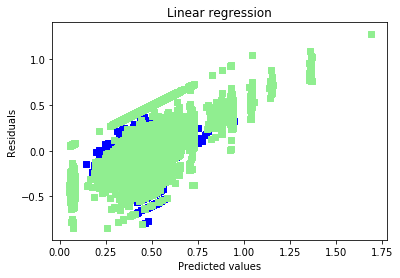

In [249]:
# Plot residuals
plt.scatter(y_train_pred, y_train_pred - Ytrain, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - Ytest, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()


When using the log-ratio as the respond, and under the linear regression model, I find the RMSE is only 0.118. and the residual plot for both the training and test data is good, so the overfit problem is not serious here. But in the linear regression, I only consider the zip code as integer, while in real life this should be categorical data. But with the number of zipcode almost the same with the number of instances, onehot encoder may not work well. So in order to save time on feature engineering I decided to try to use XGboosting, which should provide some variable importance information.



# XGBoost
The most time consuming part for XGBoost is the parameter tunning, as our data set is not so huge, so we don't need to worry about the computation time. Three kind parameters may be needed to tune.
- General Parameters: Guide the overall functioning
- Booster Parameters: Guide the individual booster (tree/regression) at each step
- Learning Task Parameters: Guide the optimization performed


In [250]:
# formatting for xgb
dtrain = xgb.DMatrix(Xtrain, label=Ytrain)
dtest = xgb.DMatrix(Xtest)


In [257]:
def xgb_cross_validation(xgb_regressor, cv_paramters, dtrain, 
             cv_folds = 5,early_stopping_rounds = 50):
             
    """
    xgb model cross validate to choose best param from giving cv_paramters.
    
    @param cv_paramters:dict,where to choose best param. {'param':[1,2,3]}
    @param dtrain:xgboost.DMatrix, training data formatted for xgb
    @param early_stopping_rounds: Activates early stopping.Stop when perfomance 
                                  does not improve for some rounds
    """
    # get initial parameters
    xgb_param = xgb_regressor.get_xgb_params()
    
    # save best param
    best_params = {}
    best_cvresult = None
    min_mean_rmse = float("inf")
    
    for param, values in cv_paramters.items():
        best_param = values[0]
        for value in values:
            # set the param's value
            xgb_param[param] = value
            
            # cv to tune param from values
            cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=xgb_param['n_estimators'], 
                              nfold=cv_folds, metrics='rmse', 
                              early_stopping_rounds=early_stopping_rounds)

            # calcuate the mean of several final rmses
            round_count = cvresult.shape[0]
            mean_rmse = cvresult.loc[round_count-11:round_count-1,'test-rmse-mean'].mean()
     
            if mean_rmse < min_mean_rmse:
                best_param = value
                best_cvresult = cvresult
                min_mean_rmse = mean_rmse
        
        best_params[param] = best_param
        # set best param value for xgb params, important
        xgb_param[param] = best_param
    
    return best_params, min_mean_rmse, best_cvresult

In [258]:
def xgb_fit(xgb_regressor, Xtrain, Ytrain,
              CV=True, cv_folds=5):
    
    # Perform cross-validation
    if CV:
        xgb_param = xgb_regressor.get_xgb_params()
        cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=xgb_param['n_estimators'], 
                              nfold=cv_folds, metrics='rmse', 
                              early_stopping_rounds=50)
        round_count = cvresult.shape[0]
        mean_rmse = cvresult.loc[round_count-11:round_count-1,'test-rmse-mean'].mean()
        std_rmse = cvresult.loc[round_count-11:round_count-1,'test-rmse-std'].mean()
        print ("CV RMSE : Mean = %.7g | Std = %.7g" % (mean_rmse, std_rmse))
    # fir the train data
    xgb_regressor.fit(Xtrain, Ytrain)
    
    # Predict training set
    train_preY = xgb_regressor.predict(Xtrain)
    mse = np.sqrt(mean_squared_error(Ytrain, train_preY))
    
    
   
    feature_importances = pd.Series(xgb_regressor.feature_importances_, Xtrain.columns.values)
    feature_importances = feature_importances.sort_values(ascending=False)
    feature_importances= feature_importances.head(10)
    feature_importances.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    return xgb_regressor, feature_importances

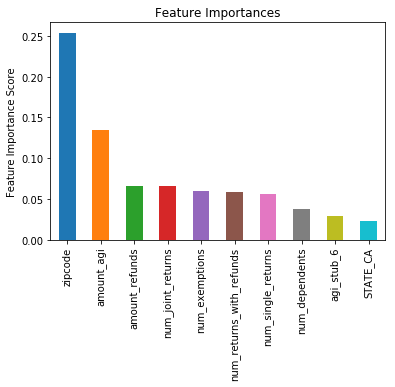

In [253]:
xgb_regressor = XGBRegressor(seed=10)
xgb_regressor, feature_importances = xgb_fit(xgb_regressor,Xtrain, Ytrain_num)

Although this is the rough idea of using XGBoosting without any tunning parameters, it shows the importance in zipcode.

### General Parameters: Guide the overall functioning

In [260]:
# In order to speedup, I start at a large learning rate
param_test = {'n_estimators':range(300,400,10)}

xgb_regressor = XGBRegressor(learning_rate =0.05)
               

best_param, min_mean_rmse, best_cvresult = xgb_cross_validation(xgb_regressor, param_test, dtrain)
                


print ('the minimum mse after cross validation using xgboost:', min_mean_rmse)

the minimum mse after cross validation using xgboost: 0.09670936363636363


## tuning tree based parameters
For the tree parameters tunning, as our zipcode is identifical to number of instances so the max_depth should not be so large in order to escape overfitting.

In [261]:
param_test = {'max_depth':range(5,10,1)}

xgb_regressor = XGBRegressor(
                learning_rate =0.05,
                n_estimators = 300)

best_param, min_mean_rmse, best_cvresult = model_cross_validate(xgb_regressor, param_test, dtrain)
                


the minimum mse after cross validation using xgboost by tuning the trees parameters: 0.09323799999999999


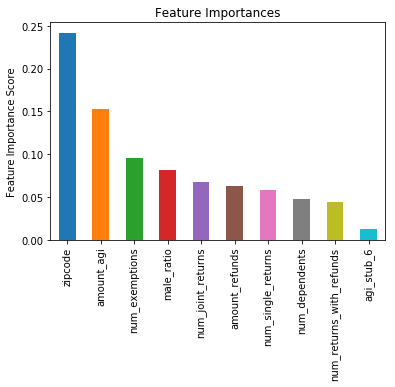

In [263]:
xgb_regressor = XGBRegressor(
                learning_rate =0.05,
                n_estimators = 300,
                max_depth=6)

xgb_regressor, feature_importances = model_fit(xgb_regressor,Xtrain, Ytrain)
print ('the minimum mse after cross validation using xgboost by tuning the trees parameters:', min_mean_rmse)

# Conclusions
In this data challenge, after conduct the data analysis and feature engineering, I have applied the simplest  linear regression model  and XGBoosting model. The reponse I have considered are the ratios of  people using paid tax preparers, and in linear regression, we have used the log norm of the ratio to satisify the model assumptions. And for the Linear Regression model, we find the mse is 0.111, and for the best XGBoost model, the mse is 0.093. After tuning parameters there is a slightly improvement in mse, which indicate the possible  During the feature engineering I found the zipcode should be very important which is also confirmed by the XGBoost model by ploting the variable importance. But  due to the time limit, I have some idears on how to explore the zipcode, as the current models have alreday performed well using MSE metrics, I didn't try the ideas here.  

This ratio prediction problem is mainly regarded as a regression problem, but if for real life use, this can also be treated as a classification problem, by setting different thresholds on the oredicted ratio, as we  may care more about whether people would like to pay for tax preparers.

### Future steps:
- Encoding zipcode in different ways like: clustering methos(KNN), dimension reduction(PCA), using coordinates to represent zipcode
- Try tunning more carefully on XGBoost
- Based on the variable importance, creat feature combinations into the X matrix
- Try to change the problem into classification problem, evaluate the model using F1 score and AUC, to compare the performance between different models, this is based on the goal that we want to predict what features peole have will prefer to pay for tax preaprers.
